Create database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import engarde.decorators as ed

import toolbox.toolbox as tb

pd.set_option('display.max_colwidth', None)


data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'

foods = tb.read(data)
foods.info()

/Users/fgu/miniconda3/envs/basics/lib/python3.7/site-packages/engarde/checks.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       991 non-null    object 
 1   category   991 non-null    object 
 2   units      991 non-null    object 
 3   calories   991 non-null    int64  
 4   fat        991 non-null    float64
 5   carbs      991 non-null    float64
 6   fiber      991 non-null    float64
 7   protein    991 non-null    float64
 8   net_carbs  991 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 77.4+ KB


In [2]:
foods.head()

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
0,agar agar,verschiedenes/gelier- und bindemittel,pro 100g essbarer Anteil,160,0.2,0.0,74.1,2.4,-74.1
1,agavensirup,süssigkeiten/zucker und süssstoffe,pro 100g essbarer Anteil,293,0.0,73.1,0.0,0.2,73.1
2,"älplermagronen, zubereitet",gerichte/sonstige salzige/rezente gerichte,pro 100g essbarer Anteil,183,9.0,18.6,1.7,6.0,16.9
3,"amaranth, samen, gekocht (ohne zugabe von fett und salz)","getreideprodukte, hülsenfrüchte und kartoffeln/sonstige getreideprodukte",pro 100g essbarer Anteil,126,2.4,19.1,3.7,5.3,15.4
4,"amaranth, samen, roh","getreideprodukte, hülsenfrüchte und kartoffeln/sonstige getreideprodukte",pro 100g essbarer Anteil,376,7.0,56.8,11.0,15.8,45.8


Find items

In [3]:
tb.find_item(foods, 'hühnere')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
315,"hühnerei, ganz, festgekocht",eier,pro 100g essbarer Anteil,157,11.4,0.3,0.0,13.2,0.3
316,"hühnerei, ganz, roh",eier,pro 100g essbarer Anteil,142,10.3,0.3,0.0,11.9,0.3
317,"hühnereigelb, roh (eidotter)",eier,pro 100g essbarer Anteil,350,31.5,0.2,0.0,16.5,0.2
318,"hühnereiweiss, roh (eiklar)",eier,pro 100g essbarer Anteil,44,0.1,0.3,0.0,10.5,0.3


Build dataset with my foods 

In [4]:
my_foods = {
    'avocado, roh': 'avocado',
    'blattsalat (durchschnitt), roh': 'lettuce',
    'champignon, roh': 'mushrooms',    
    'fleisch (durchschnitt exkl. innereien), roh': 'meat',
    'gemüse (durchschnitt), roh': 'vegetables',
    'hart- und halbhartkäse, vollfett (durchschnitt)': 'cheese',
    'hühnerei, ganz, festgekocht': 'eggs',
    'kakaopulver': 'cocoa powder', 
    'kochbutter': 'butter',
    'kokosfett': 'coconut fat',
    'kokosnuss, getrocknet (kokosrapseln, kokosflocken)': 'coconut flakes',
    'mandel': 'almond',
    'olivenöl': 'olive oil',
    'peperoni, rot, roh': 'red pepper',
    'poulet, schenkel, mit haut, gebraten (ohne zusatz von fett und salz)': 'chicken leg',
    'poulet, brust, schnitzel oder geschnetzeltes, gebraten (ohne zusatz von fett und salz)': 'chicken breast',
    'samen, kerne, nüsse (durchschnitt), ungesalzen': 'nuts and seed mix',
    'schwein, hals, steak, gebraten (ohne zusatz von fett und salz)': 'pork steak',
    'spinat, roh': 'spinach', 
    'tofu': 'tofu',
}


myfoods = tb.make_myfoods(foods, my_foods)

tb.find_item(myfoods, 'egg')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
315,eggs,eier,pro 100g essbarer Anteil,157,11.4,0.3,0.0,13.2,0.3


ValueError: not enough values to unpack (expected 3, got 2)

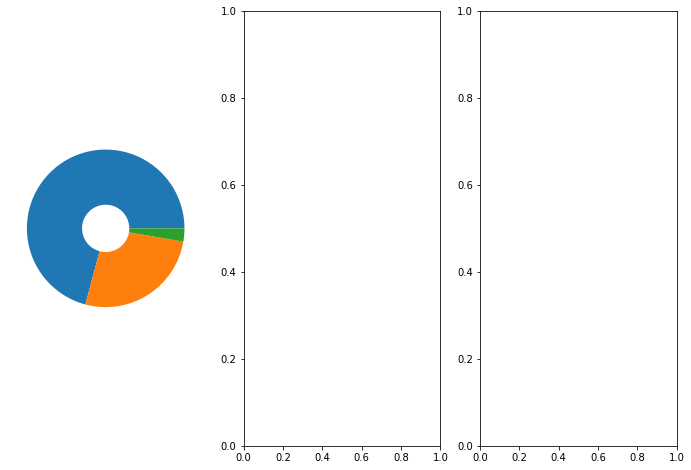

In [5]:
def make_doughnut(data, title, axis):
    """
    Create a piechart based on nutrition data.
    """
    calories = data[0]
    macros = data[1:]
    
    def func(pct, allvals):
        absolute = int(pct / 100 * sum(allvals))
#         return f"{pct:.1f}%\n({absolute:.1f} g)"
        return f"{pct:.1f}%"

#     wedges, _, _ = ax[axis].pie(macros, wedgeprops=dict(width=0.7),
#                           textprops=dict(color='white', size=15),
#                           autopct=lambda pct: func(pct, macros))
    wedges, _, _ = ax[axis].pie(macros, wedgeprops=dict(width=0.7),
                          textprops=dict(color='white', size=15),
                          labels=['fa', 'pro', 'car'])
    ax[axis].legend(wedges, macros.index,
              bbox_to_anchor=(.3, -1, .5, 1),
              fontsize=15)
    ax[axis].set_title(f'{title}\n (calories: {calories})',
                 fontdict=dict(size=18));
    

# creatine_bomb = {
#     'cocoa powder': 0.1,
#     'coconut fat': 0.5,
#     'coconut flakes': 0.1,
#     'almond': 0.2,
# }

# snack = {
#     'egg': 1.3,
#     'olive oil': 0.2,
#     'spinach': 0.4,
#     'mushrooms': 0.5,
# }

lunch = {
    'lettuce': 2,
    'avocado': 1.5,
    'olive oil': .2,
    'red pepper': 1,
    'eggs': 2, 
    'nuts and seed mix': .5,
    'cheese': 0,
}

supper = {
    'vegetables': 0,
    'avocado': 1.5,
    'butter': .2,
    'pork steak': 0,
    'cheese': 0
}

meals = [lunch, supper]
total_nuts = pd.concat([tb.calc_nutrients(myfoods, meal) for meal in meals], axis=1).sum(axis=1)
lunch_nuts = pd.DataFrame(tb.calc_nutrients(myfoods, lunch)).sum(axis=1)
supper_nuts = pd.DataFrame(tb.calc_nutrients(myfoods, supper)).sum(axis=1)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
make_doughnut(total_nuts, 'total', 0)
make_doughnut(lunch_nuts, 'lunch', 1)
make_doughnut(supper_nuts, 'supper', 2)

In [ ]:
pd.Series.it

# New

Define meals

In [6]:
lunch = {
    'lettuce': 2,
    'avocado': 1.5,
    'olive oil': .2,
    'red pepper': 1,
    'eggs': 2, 
    'nuts and seed mix': .5,
    'cheese': 0,
}

supper = {
    'vegetables': 0,
    'avocado': 1.5,
    'butter': .2,
    'pork steak': 0,
    'cheese': 0
}

meals = [lunch, supper]

Calc nuts for each meal and for day

In [7]:
def calc_nutrients(data, meal):
    
    nutrients = ['calories', 'fat', 'protein', 'net_carbs']
    
    data = data.loc[data.name.isin(meal), nutrients].sum()
    
    grams = data[1:].copy()
    grams['total'] = grams.sum()
    
    cals = data[1:].copy()
    cals['fat'] = grams.fat * 9
    cals['protein'] = grams.protein * 4
    cals['net_carbs'] = grams.net_carbs * 4
    cals['total'] = data['calories']
    
    nuts = pd.concat([grams, cals], axis=1)
    nuts = nuts.reindex(['total', 'fat', 'protein', 'net_carbs'])
    nuts[nuts < 0] = 0
    nuts.columns = ['grams', 'cals']
    
    return nuts

    
meal_nuts = [calc_nutrients(myfoods, meal) for meal in meals]    
meal_nuts.append(sum(meal_nuts))

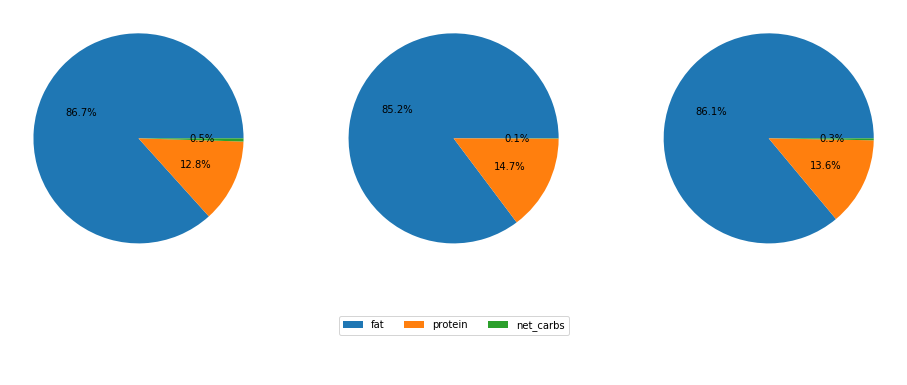

In [45]:
def make_doughnut(data, axis):
    nuts = data[1:]
    ax[axis].pie(nuts.cals, autopct='%2.1f%%')

    
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

make_doughnut(meal_nuts[0], 0)
make_doughnut(meal_nuts[1], 1)
make_doughnut(meal_nuts[2], 2)

fig.legend(meal_nuts[0].index[1:], loc='lower center', borderaxespad=5, ncol=3);